## EDA related to ESM embeddings and sORF prediction
__Feb 2024__<br>
__Keith Cheveralls__


In [48]:
import torch
import esm
import numpy as np
import umap

import sklearn
import sklearn.decomposition
import sklearn.ensemble

In [56]:
from Bio import SeqIO

In [49]:
# for some reason these import statements must be called explicitly, and in this order
import esm.data
import esm.pretrained

In [50]:
import matplotlib.pyplot as plt

In [51]:
import smallesm
import smallesm.train

In [5]:
torch.cuda.is_available()

True

In [6]:
%load_ext autoreload
%autoreload 2

## Explore fasta files

In [83]:
def plot_sequence_lengths_histogram(fasta_file, bins=50):
    seq_lengths = np.array([len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")])

    p = 0.1
    [min_length, max_length] = np.percentile(seq_lengths, (p, 100 - p))
    seq_lengths = seq_lengths[seq_lengths > min_length]
    seq_lengths = seq_lengths[seq_lengths < max_length]
    
    counts, edges = np.histogram(seq_lengths, bins=bins)
    plt.bar(edges[1:], np.log(counts + 1), width=(edges[1] - edges[0]), alpha=0.3)

(0.0, 1000.0)

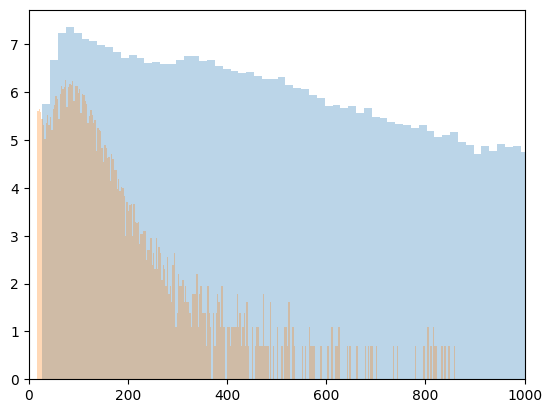

In [97]:
plt.figure()
filepath = '../tmp/data/coding_train_and_test_10x_subsampled_peptides.fa'
plot_sequence_lengths_histogram(filepath, bins=300)

filepath = '../tmp/data/noncoding_train_and_test_10x_subsampled_dedup_peptides.fa'
plot_sequence_lengths_histogram(filepath, bins=300)

plt.xlim([0, 1000])

(0.0, 1000.0)

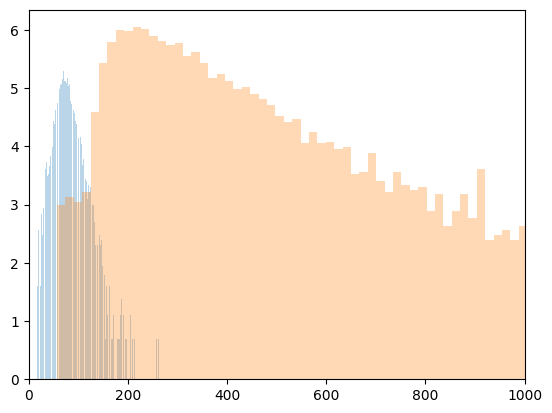

In [92]:
plt.figure()
filepath = '../tmp/data/coding_validation_peptides.fa'
plot_sequence_lengths_histogram(filepath, bins=300)

filepath = '../tmp/data/noncoding_validation_peptides.fa'
plot_sequence_lengths_histogram(filepath, bins=300)

plt.xlim([0, 1000])

## Generating ESM embeddings

This roughly follows the example code in the ESM repo readme.

In [6]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
]

In [7]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# this is the sequence length 
# (in tokens, not amino acids; they appear to be only approx equal)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

In [8]:
# Extract per-residue representations
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)

token_representations = results["representations"][33]

In [9]:
token_representations.shape

torch.Size([2, 73, 1280])

In [ ]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

In [25]:
np.array(sequence_representations).shape

(4, 1280)

In [ ]:
# Look at the unsupervised self-attention map contact predictions
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

## Load embeddings

These are generated by `smallesm embed`. 

In [108]:
coding_train_filepath = '../tmp/data/coding_train_and_test_10x_subsampled_embeddings.npy'
noncoding_train_filepath = '../tmp/data/noncoding_train_and_test_10x_subsampled_embeddings.npy'
coding_test_filepath = '../tmp/data/coding_validation_embeddings.npy'
noncoding_test_filepath = '../tmp/data/noncoding_validation_embeddings.npy'

In [110]:
X, y = smallesm.train.load_data_and_labels(
    coding_filepath=coding_train_filepath,
    noncoding_filepath=noncoding_train_filepath,
    max_length=100,
)   

X_test_true, y_test_true = smallesm.train.load_data_and_labels(
    coding_filepath=coding_test_filepath,
    noncoding_filepath=noncoding_test_filepath,
    max_length=100,
)   

In [111]:
X.shape, y.shape, X_test_true.shape, y_test_true.shape

((15818, 320), (15818,), (7493, 320), (7493,))

## Train and validate using the smallesm.train function


In [98]:
smallesm.train.train(
    coding_train_filepath=coding_train_filepath,
    noncoding_train_filepath=noncoding_train_filepath,
    coding_test_filepath=coding_test_filepath,
    noncoding_test_filepath=noncoding_test_filepath,
)

Training metrics
Accuracy: 0.97
Precision: 0.99
Recall: 0.96
F1: 0.98
Validation metrics
Accuracy: 0.88
Precision: 0.92
Recall: 0.89
F1: 0.91
Test metrics
Accuracy: 0.21
Precision: 0.31
Recall: 0.35
F1: 0.33


In [103]:
smallesm.train.train(
    coding_train_filepath=coding_train_filepath,
    noncoding_train_filepath=noncoding_train_filepath,
    coding_test_filepath=coding_test_filepath,
    noncoding_test_filepath=noncoding_test_filepath,
    max_length=100,
)   

Training metrics
Accuracy: 0.97
Precision: 0.96
Recall: 0.96
F1: 0.96
Validation metrics
Accuracy: 0.90
Precision: 0.88
Recall: 0.82
F1: 0.85
Test metrics
Accuracy: 0.17
Precision: 0.95
Recall: 0.17
F1: 0.29


## EDA

In [21]:
# aside: scaling features is not nec for random forest but may be for SVM w rbf
# (but also may not be, since we're dealing w embeddings from some hidden layer).
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)

x_scaled = scaler.transform(X)
x_test_scaled = scaler.transform(X_test)

### PCA and explained variance

In [112]:
np.random.seed(0)

pca = sklearn.decomposition.PCA(n_components=30)
pca.fit(X)

X_pcs = pca.transform(X)
X_test_true_pcs = pca.transform(X_test_true)

Text(0, 0.5, 'Variance Explained')

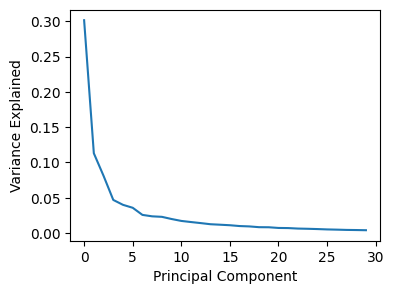

In [113]:
plt.figure(figsize=(4, 3))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [114]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0)

In [115]:
X_coords = umap_model.fit_transform(X_pcs)

In [116]:
def plot_umap(coords, y, labels=('noncoding', 'coding')):

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    for ax in (axs[0], axs[-1]):
        ax.scatter(coords[y == 0, 0], coords[y == 0, 1], color='#333', s=2, alpha=0.1, label=labels[0])

    for ax in (axs[1], axs[-1]):
        ax.scatter(coords[y == 1, 0], coords[y == 1, 1], color='#f33', s=2, alpha=0.1, label=labels[1])
    
    for ax in axs:
        ax.legend()

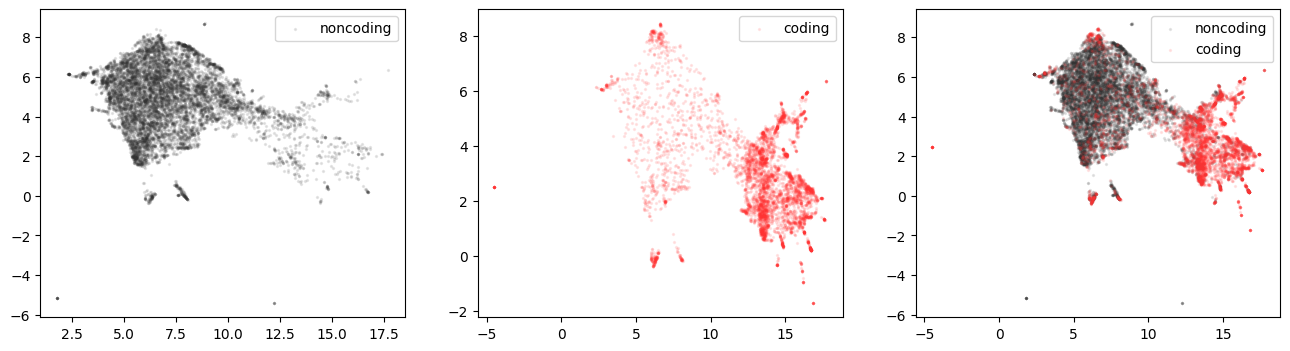

In [117]:
# less than 100a
plot_umap(X_coords, y)

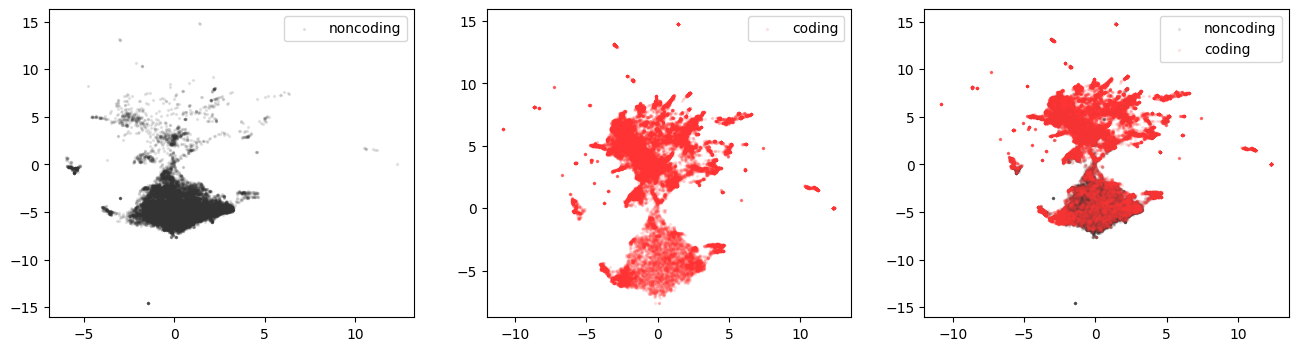

In [44]:
# all seqs
plot_umap(X_coords, y)

In [118]:
X_test_true_coords = umap_model.fit_transform(X_test_true)

In [120]:
(y_test_true == 1).sum(), y_test_true.shape

(7421, (7493,))

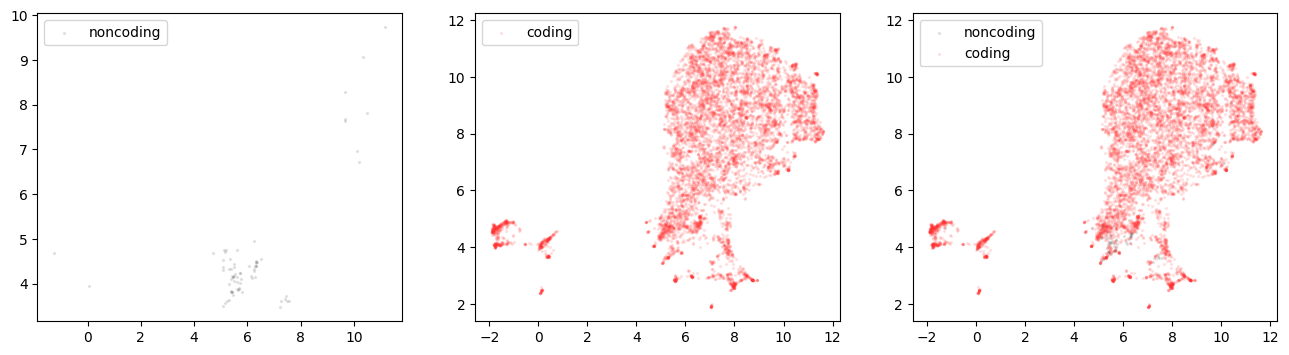

In [119]:
# less than 100aa
plot_umap(X_test_true_coords, y_test_true)

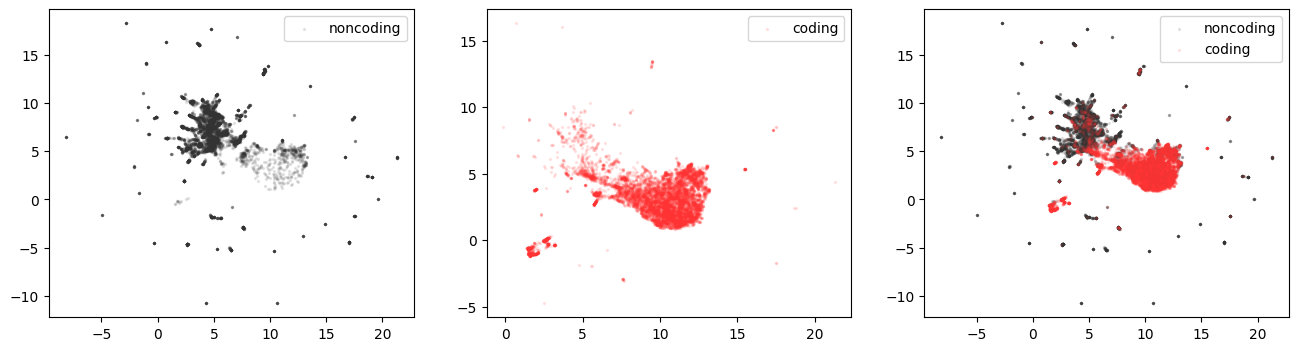

In [38]:
# all seqs
plot_umap(X_test_true_coords, y_test_true)

In [46]:
x_all = np.concatenate((X_pcs, X_test_true_pcs), axis=0)
is_train = np.concatenate((np.ones(len(X_pcs)), np.zeros(len(X_test_true_pcs))), axis=0)

x_all_coords = umap_model.fit_transform(x_all)

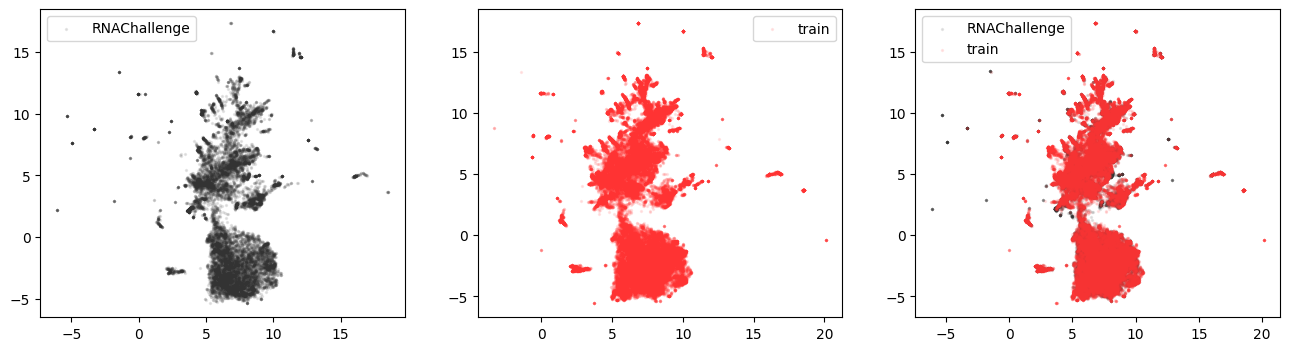

In [47]:
plot_umap(x_all_coords, train_or_test, labels=('RNAChallenge', 'train'))

### Train a classifier

In [35]:
# split the combined training_and_test data into train and test
# (ignoring for now the true test data, which is the coding/noncoding_validation files)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_pcs,
    y,
    shuffle=True,
    test_size=0.2,
)

In [36]:
model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=30,
    min_samples_split=10, 
    class_weight='balanced',
    random_state=0,
    oob_score=True, 
    n_jobs=-1
)

In [37]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=30, n_jobs=-1, oob_score=True,
                       random_state=0)

In [40]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9699919090000476, 0.8784504092899296)

In [41]:
model.score(X_test_true_pcs, y_test_true)

0.2116919270027838

In [61]:
preds = model.predict_proba(X_test)

In [62]:
preds.shape

(10506, 2)

In [63]:
model.classes_

array([0., 1.])

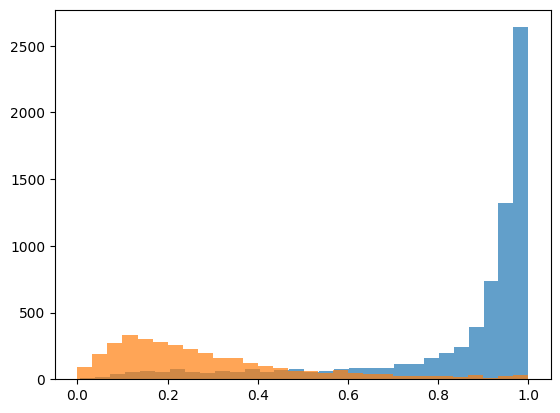

In [65]:
# predicted probablity that the transcript is coding
prob_coding = preds[:, 1]

_ = plt.hist(prob_coding[y_test == 1], bins=30, alpha=0.7)
_ = plt.hist(prob_coding[y_test == 0], bins=30, alpha=0.7)

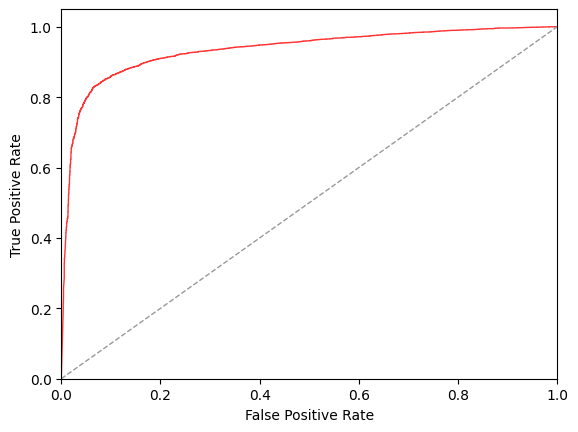

In [68]:
prob_coding = preds[:, 1]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, prob_coding)

plt.figure()
plt.plot(fpr, tpr, color='#f33', lw=1)
plt.plot([0, 1], [0, 1], color='#999', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()